In [ ]:
from PIL import Image
from torchvision import transforms
import torch

transform = transforms.Compose(
            [transforms.ToTensor()]
        )

segmap_img_path = '/home/Lev/Projects/diffusion_finetuning/data/bin_seg_maps/2011_003271.jpg'
segmap_instance_image = Image.open(segmap_img_path)
segmap_instance_image = transform(segmap_instance_image)
print(torch.unique(segmap_instance_image))


In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
from diffusers import StableDiffusionPipeline
import torch

model_path = "sayakpaul/sd-model-finetuned-lora-t4"
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.unet.load_attn_procs(model_path)
pipe.to("cuda")

prompt = "A pokemon with blue eyes."
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5, cross_attention_kwargs={"scale": 0.5}).images[0]
image

Fetching 16 files:  81%|████████▏ | 13/16 [00:01<00:00, 11.85it/s]


OSError: [Errno 28] No space left on device

: 

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda:4")

100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


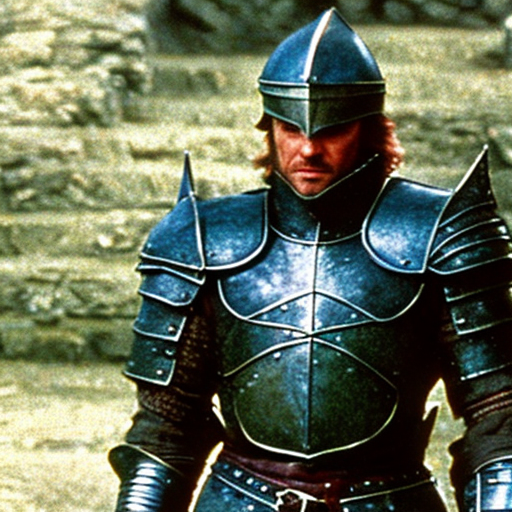

In [49]:
img = pipe(prompt='dvd screengrab, dark fantasy film from 1982 ,knight in armor, dragon',negative_prompt='weird, distorted', num_inference_steps=40).images[0]
img

In [3]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:3')
img = Image.open('/disk4/Lev/Projects/diffusion_finetuning/data/original_val/2007_000175.jpg').convert('RGB').resize([512,512])


Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 6335.81it/s]


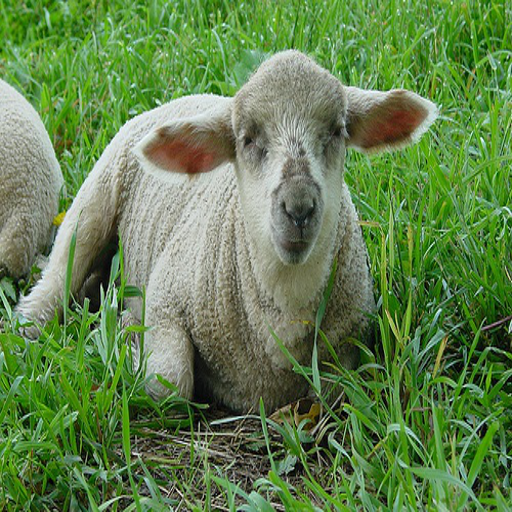

In [22]:
img

In [20]:
prompt = "black sheep"
diff_img = pipe(prompt=prompt, image=img, strength=0.7, guidance_scale=8).images[0]

100%|██████████| 35/35 [00:03<00:00, 11.46it/s]


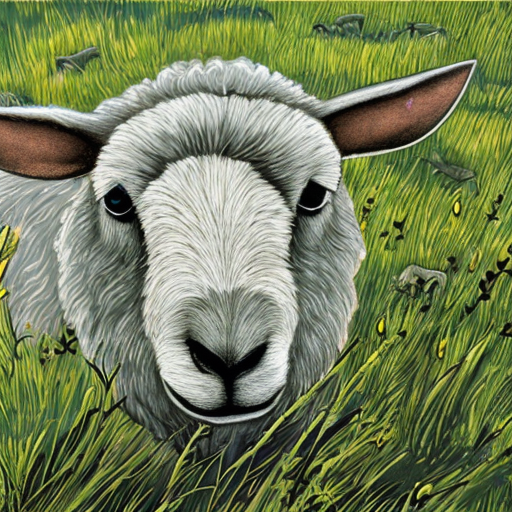

In [21]:
diff_img

### Test Segmentation Mask

In [14]:
import numpy as np

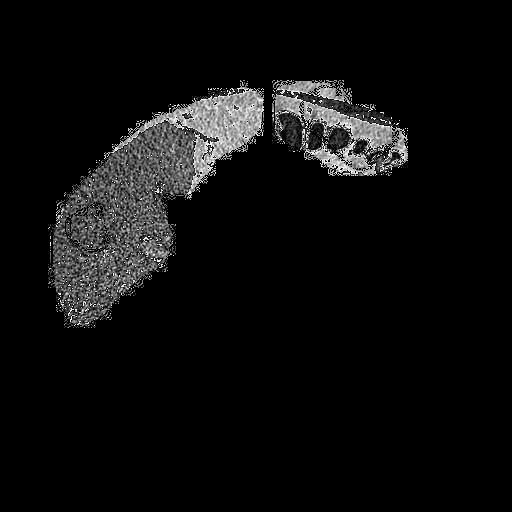

In [3]:
from PIL import Image
import numpy as np
img = Image.open('./img.jpeg').convert('RGB').copy()
mask = Image.open('./segmap_img.jpeg').convert('RGB').copy()

img = np.asarray(img).copy()
mask = np.asarray(mask)
mask = np.all(mask == [0, 0, 0], axis=-1)

img[mask] = [0,0,0]
img = Image.fromarray(img).convert('RGB')
img

### Test VAE on LITS17 Dataset

In [16]:
from training_scripts.LITS17Dataset import LITS17Dataset
from transformers import CLIPTokenizer
#vae = pipe.vae.to('cuda:1')
# tokenizer = CLIPTokenizer.from_pretrained(
#             args.tokenizer_name,
#             revision=args.revision,
ct_dir = 
lits17ds = LITS17Dataset()

### Test VAE of Img2Img pipeline

torch.Size([1, 3, 512, 512])


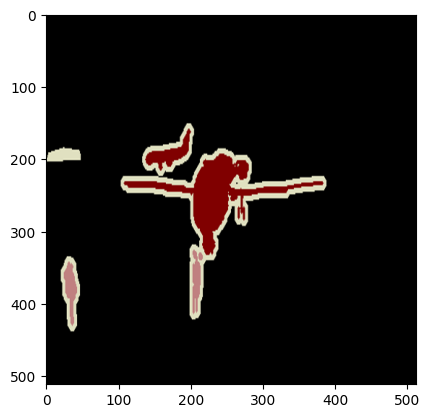

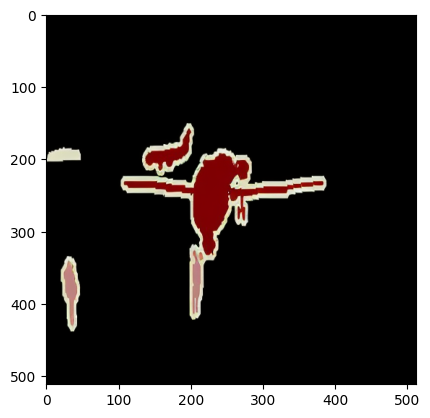

In [48]:
vae = pipe.vae.to('cuda:1')

img_transforms = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ]
)
plt.figure(1)
tst_img_path = "./data/seg_maps_class_train/2007_000032.png"
tst_img = Image.open(tst_img_path).convert('RGB').resize([512,512])
plt.imshow(tst_img)
tst_img = img_transforms(tst_img).to('cuda:1', dtype=torch.float16)
tst_img = tst_img.unsqueeze(0)
# tst_img = torch.stack(tst_img).to(memory_format=torch.contiguous_format).float()
print(tst_img.shape)

tst_img_latents = vae.encode(tst_img).latent_dist.sample()
tst_img_latents *= 0.18215
#decoded_img = vae.decode(tst_img_latents).sample.detach().cpu().squeeze()
decoded_img = decode_latents(vae, tst_img_latents).squeeze()
plt.figure(2)
plt.imshow(decoded_img)

In [47]:
def decode_latents(vae, latents):
        latents = 1 / 0.18215 * latents
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.detach().cpu().permute(0, 2, 3, 1).float().numpy()
        return image

### Test Trained UNET (for segmentation)

In [30]:
%load_ext autoreload
%autoreload 2 

In [1]:
from training_scripts.segmentation_metrics import convert_seg_array_to_binary_rgb
from training_scripts.pretrained_segmentation_head import detection_mask_rcnn

def replace_unet_in_pipeline(pipe, path_to_weights=None, device='cuda'):
    unet = pipe.unet
    tmp = unet.conv_out
    n_noise_pred_channels = unet.conv_out.out_channels

    new_layer =  torch.nn.Conv2d(tmp.in_channels, tmp.out_channels * 2, kernel_size=tmp.kernel_size, padding=tmp.padding, bias=True, dtype=torch.float16) # Add 2 channels to serve for segmentation
    if path_to_weights:
        # load weights
        chkpt = torch.load(path_to_weights)
        new_layer.load_state_dict(chkpt['conv_out_state_dict'])
    else:
        # init weights to pipe weights
        new_layer.weight.data[:tmp.weight.data.shape[0], :, :, :] = tmp.weight.data[:, :, :, :]
    new_layer.to(device=device)
    unet.conv_out = new_layer
    return

import xml.etree.ElementTree as ET
import os

def get_annotations(img_paths, annotations_root):
    voc_classes = {'background' : 'background',
                    'aeroplane' : 'aeroplane',
                    'bicycle' : 'bicycle',
                    'bird' : 'bird',
                    'boat' : 'boat',
                    'bottle' : 'bottle',
                    'bus' : 'bus',
                    'car' : 'car',
                    'cat' : 'cat',
                    'chair' : 'chair',
                    'cow' : 'cow',
                    'diningtable' : 'dining table',
                    'dog' : 'dog',
                    'horse' : 'horse',
                    'motorbike' : 'motorbike',
                    'person' : 'person',
                    'pottedplant' : 'potted plant',
                    'sheep' : 'sheep',
                    'sofa' : 'sofa',
                    'train' : 'train',
                    'tvmonitor' : 'tv monitor'}

    images_names = [os.path.splitext(os.path.basename(path))[0] for path in img_paths]
    xmls_paths = [os.path.join(annotations_root, img_name +'.xml') for img_name in images_names]
    
    annotations = []
    for path in xmls_paths:
        tree = ET.parse(path)
        root = tree.getroot()
        annontation = root.find('object/name')

        annotations += [voc_classes[annontation.text]]

    return annotations

# Sample random pics and get their seg
import os
from os import walk
import random

def diffuse_random_imgs(img_folder, pipe, prompt, strength, guidance,
                        neg_prompt=None, n_examples=3, save_path=None, rcnn=False):
    
    f = next(walk(img_folder), (None, None, []))[2]
    filenames = [os.path.join(img_folder, filename) for filename in f]
    filenames = random.sample(filenames, n_examples)
    annotations_root = '/disk4/Lev/Projects/diffusion_finetuning/data/voc_pascal/Annotations/'
    annotations = get_annotations(filenames, annotations_root)

    fig , ax = plt.subplots(n_examples, 3, figsize=(48,48))
    for i, item in enumerate(zip(filenames, annotations)):
        f, annotation = item
        init_image = Image.open(f).convert("RGB").resize((512, 512))
        ax[i, 0].imshow(init_image, aspect='auto')
        ax[i, 0].axis('off')
        
        full_prompt = prompt + ' ' + annotation
        image = pipe(prompt=full_prompt, image=init_image, strength=strength, guidance_scale=guidance, modified_unet=True, segmentation=True).images[0]
        ax[i, 1].imshow(image, aspect='auto')
        ax[i, 1].axis('off')
        ax[i, 1].set_title(full_prompt + ' ' + f, fontsize=40)
        
        seg_arr = convert_seg_array_to_binary_rgb(image, 200)
        seg_img = Image.fromarray(seg_arr).convert('RGB')
        ax[i, 2].imshow(seg_img, aspect='auto')
        ax[i, 2].axis('off')
        if rcnn:
            detection_mask_rcnn(image)

        if save_path:
            if not os.path.exists(save_path):       
                os.mkdir(save_path)
            init_image.save(os.path.join(save_path, 'original_' + os.path.basename(f)))
            image.save(os.path.join(save_path, os.path.basename(f)))

    plt.show()

/opt/miniconda3/envs/lev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
from lora_diffusion import monkeypatch_lora, tune_lora_scale

2023-02-23 18:39:52.536734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 18:39:54.369727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-23 18:39:54.369777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
%reload_ext autoreload
%autoreload 2

### Model Loading

In [8]:
from diffusers2.diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline

PATH_PREFIX = '/disk4/Lev/Projects/diffusion_finetuning/output/grounding/grounding_no_text/mse_seg_pred__prev_noisy_segmap_latent_resumed_w_text_encoder_run2'
UNET_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'unet_seg_weights.pt')
LORA_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'lora_weight.pt')
LORA_TEXT_WEIGHTS_PATH = os.path.join(PATH_PREFIX,'lora_weight.text_encoder.pt')

model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:7')
# chkpt = torch.load(UNET_WEIGHTS_PATH)
# pipe.unet.conv_out.load_state_dict(chkpt['conv_out_state_dict'])

monkeypatch_lora(pipe.unet, torch.load(LORA_WEIGHTS_PATH))
monkeypatch_lora(pipe.text_encoder, torch.load(LORA_TEXT_WEIGHTS_PATH), target_replace_module=["CLIPAttention"])

tune_lora_scale(pipe.unet, 1)
tune_lora_scale(pipe.text_encoder, 1.3)

replace_unet_in_pipeline(pipe, UNET_WEIGHTS_PATH, device=pipe.device)

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 6660.88it/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


#### Visualize model output on single/ multiple images

255   0   (512, 512, 3)


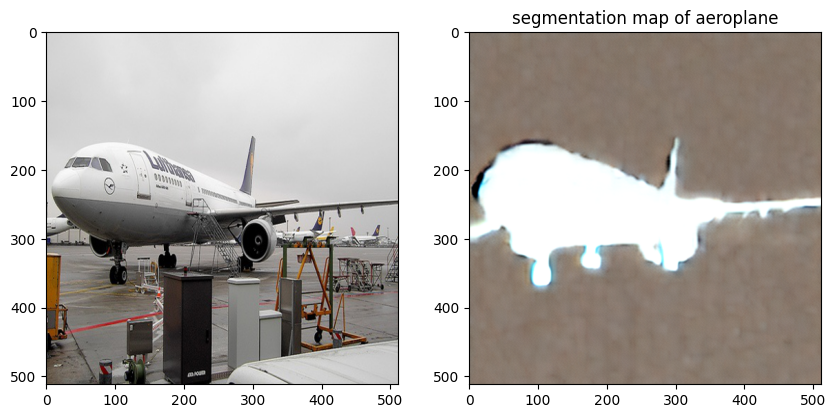

In [21]:
tst_img_path = "/disk4/Lev/Projects/diffusion_finetuning/data/voc_pascal/original_test/2007_000033.jpg"
tst_img = Image.open(tst_img_path).convert('RGB').resize([512,512])

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(tst_img)
# print(tst_img.shape)
prompt="segmentation map of aeroplane"
negative_prompt = None
# negative_prompt="person"
img = pipe(prompt=prompt,image=tst_img, strength=0.1, guidance_scale=12, modified_unet=True, segmentation=True).images[0]
img_arr = np.asarray(img)
print(img_arr.max(), ' ', img_arr.min(), ' ', img_arr.shape)
axs[1].imshow(img)
axs[1].set_title(prompt)
plt.show()

In [ ]:
diffuse_random_imgs('./data/voc_pascal/original_test/',
                    pipe,
                    "segmentation map of",
                    0.4,
                    12,
                    neg_prompt=None,
                    n_examples=4,
                    rcnn=True)

#### Test pretraine detection/segmentation methods on models output

In [ ]:
# try to segment output image from pipe using deeplab
from training_scripts.pretrained_segmentation_head import binary_segmentation_deeplab, binary_segmentation_unet, binary_segmentation_maskrcnn
import urllib

url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
input_image = Image.open(filename).convert('RGB')
segmented_img = binary_segmentation_deeplab(img)
preds = segmented_img.squeeze(0).argmax(0)
print(preds.shape)
print(np.unique(preds))

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(img)
axs[1].imshow(preds*255)
plt.show()

In [ ]:
deeplab_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
deeplab_model.eval()

In [ ]:
from training_scripts.pretrained_segmentation_head import detection_mask_rcnn
detection_mask_rcnn(img)

In [ ]:
# Teting thershold from converting to binary segmentation mask
from training_scripts.segmentation_metrics import convert_seg_array_to_binary_rgb, test_model_segmentation
seg_arr = convert_seg_array_to_binary_rgb(img, 180)
seg_img = Image.fromarray(seg_arr).convert('RGB')
seg_img

### Testing on Seen Classes

mdice: 0.185610940441978, miou: 0.1022994155879622, mAPmask: 0.03737810441136713, mAPdetect: 0.0
segmentation map of chair


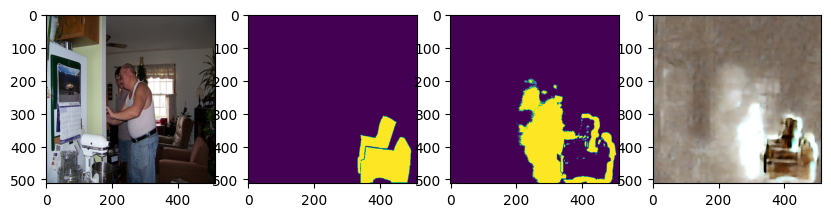

mdice: 0.5872973690753039, miou: 0.5402535398924154, mAPmask: 0.5077344804916369, mAPdetect: 0.5
segmentation map of bird


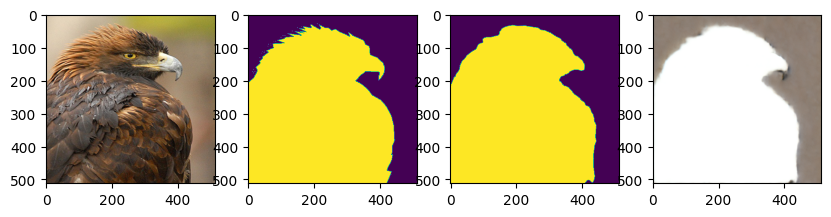

mdice: 0.6475271175876631, miou: 0.5679553552504438, mAPmask: 0.5355713422702628, mAPdetect: 0.6666666666666666
segmentation map of person


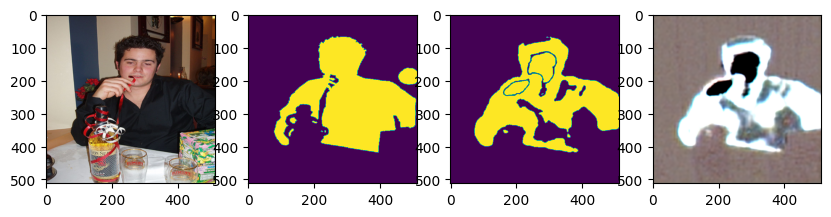

mdice: 0.6810084279224773, miou: 0.5862910561986984, mAPmask: 0.5604820373313508, mAPdetect: 0.75
segmentation map of bottle


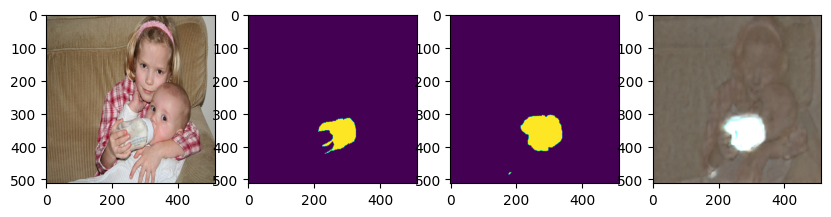

mdice: 0.6053097009178635, miou: 0.5046755464840131, mAPmask: 0.46679888481090004, mAPdetect: 0.6
segmentation map of car


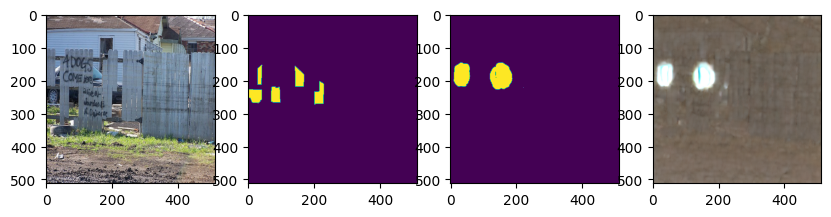

mdice: 0.6018921382027081, miou: 0.4894349772261412, mAPmask: 0.44741163409615003, mAPdetect: 0.5
segmentation map of person


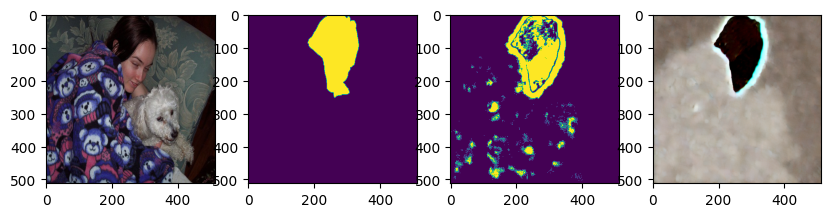

mdice: 0.5599154434149266, miou: 0.44552593950060826, mAPmask: 0.40198098441179536, mAPdetect: 0.42857142857142855
segmentation map of person


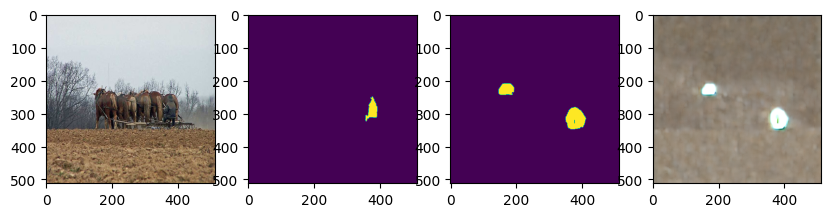

mdice: 0.6019920750991126, miou: 0.4913929280919227, mAPmask: 0.4522438085260334, mAPdetect: 0.5
segmentation map of sheep


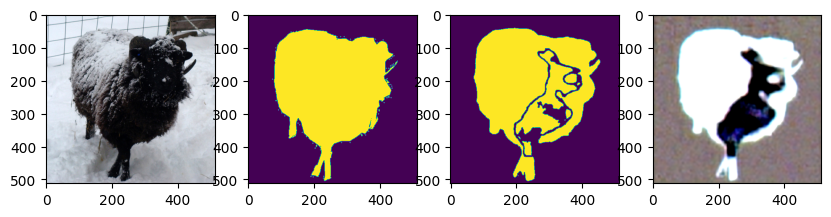

mdice: 0.5832678687647226, miou: 0.46753933105017204, mAPmask: 0.4265085231568394, mAPdetect: 0.4444444444444444
segmentation map of dog


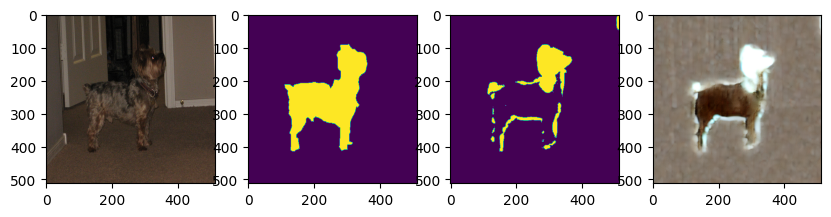

mdice: 0.5838334165951906, miou: 0.46252114248081105, mAPmask: 0.41896552450353974, mAPdetect: 0.4
segmentation map of potted plant


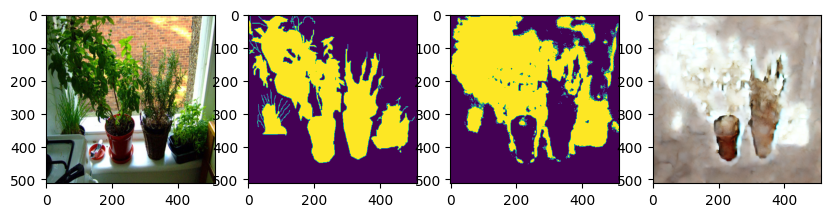

mdice: 0.5377341543546992, miou: 0.424101204959469, mAPmask: 0.3831734777283042, mAPdetect: 0.36363636363636365
segmentation map of train


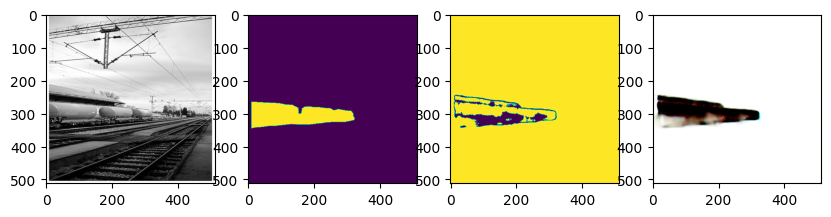

mdice: 0.49573584833657075, miou: 0.39019001889591004, mAPmask: 0.35138810171568075, mAPdetect: 0.3333333333333333
segmentation map of sofa


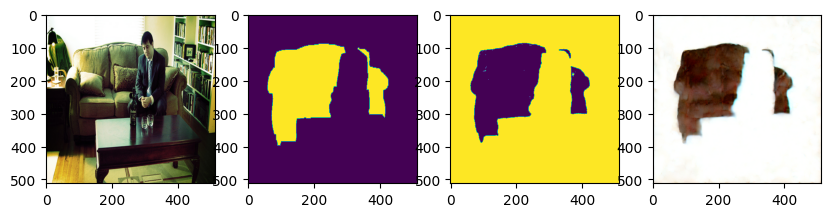

In [6]:
from training_scripts.segmentation_metrics import test_model_segmentation

imgs_paths = '/disk4/Lev/Projects/diffusion_finetuning/data/voc_pascal/original_test'
seg_paths = '/disk4/Lev/Projects/diffusion_finetuning/data/voc_pascal/seg_maps_class'
annotation_paths = '/disk4/Lev/Projects/diffusion_finetuning/data/voc_pascal/Annotations'

scores = test_model_segmentation(imgs_paths,
                                 seg_paths,
                                 annotation_paths,
                                 pipe,
                                 max_examples=10,
                                 bin_segmask_threshold=200,
                                 strength=0.1,
                                 guidance_scale=12,
                                 print_every=1)

### Testing On Unseen Classes

mdice: 0.1555300650722012, miou: 0.08432236390900531, mAPmask: 0.0405186812204441, mAPdetect: 0.0
segmentation map of rug


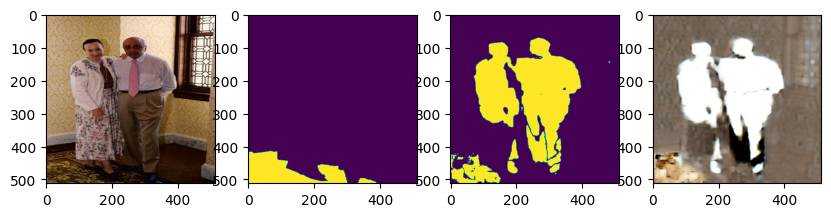

mdice: 0.10734586312448788, miou: 0.057402446513570876, mAPmask: 0.025138248953898677, mAPdetect: 0.0
segmentation map of book


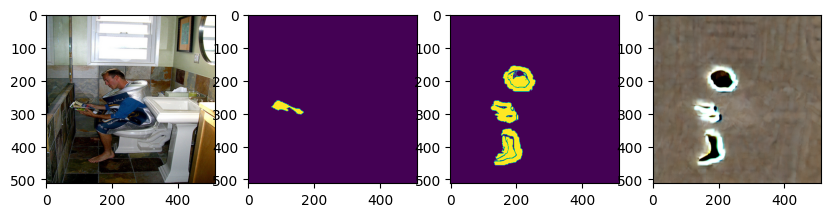

mdice: 0.07156390874965858, miou: 0.038268297675713915, mAPmask: 0.01675883263593245, mAPdetect: 0.0
segmentation map of cabinet


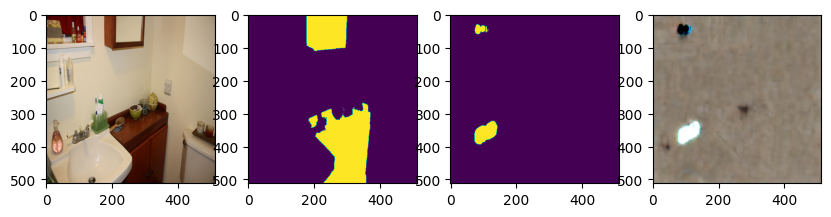

mdice: 0.2816301320198625, miou: 0.23818774600346188, mAPmask: 0.22075962580052733, mAPdetect: 0.25
segmentation map of snow


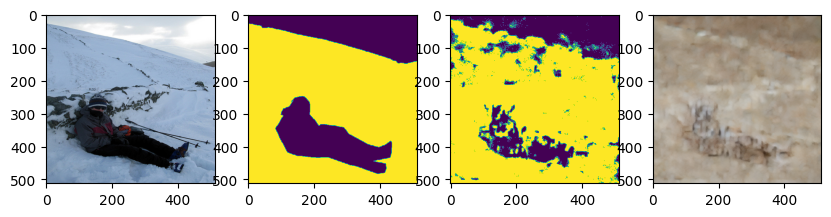

mdice: 0.26041839533682676, miou: 0.2097969300848602, mAPmask: 0.18324334600873204, mAPdetect: 0.2
segmentation map of sports ball


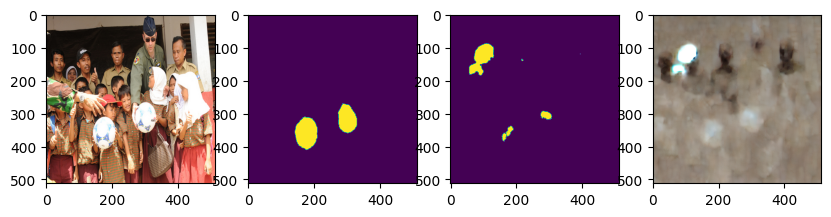

mdice: 0.23888987224416383, miou: 0.18653619884932046, mAPmask: 0.16148036417275177, mAPdetect: 0.16666666666666666
segmentation map of wall-wood


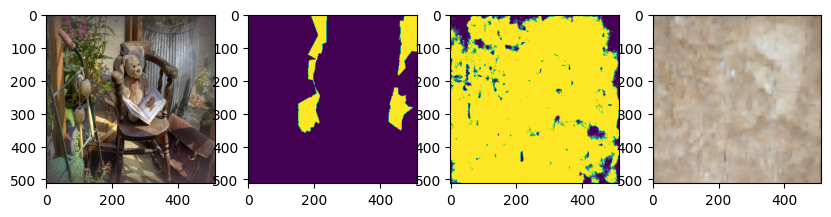

mdice: 0.2618716352145975, miou: 0.19557592137654897, mAPmask: 0.17064724040714122, mAPdetect: 0.14285714285714285
segmentation map of wall-other


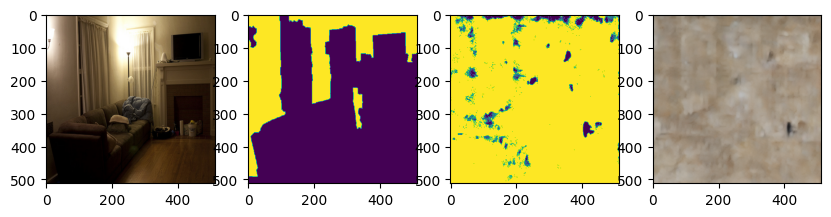

mdice: 0.2985793623988745, miou: 0.21920320590150572, mAPmask: 0.1953864445180466, mAPdetect: 0.125
segmentation map of refrigerator


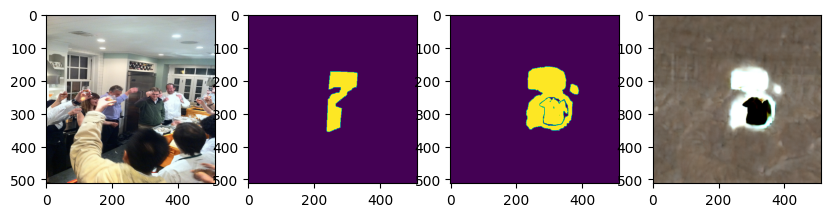

mdice: 0.269001740547452, miou: 0.1966758302644832, mAPmask: 0.17381776035923469, mAPdetect: 0.1111111111111111
segmentation map of rug


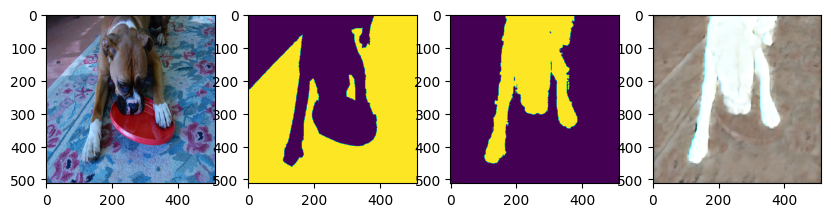

mdice: 0.24417563227714947, miou: 0.1780561471975136, mAPmask: 0.1564879436586569, mAPdetect: 0.1
segmentation map of window-other


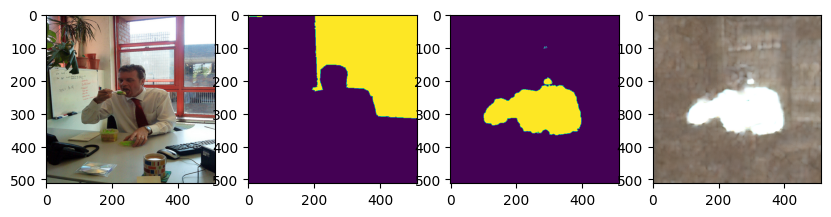

mdice: 0.22744679345816407, miou: 0.16468849922058743, mAPmask: 0.14508104145799042, mAPdetect: 0.09090909090909091
segmentation map of surfboard


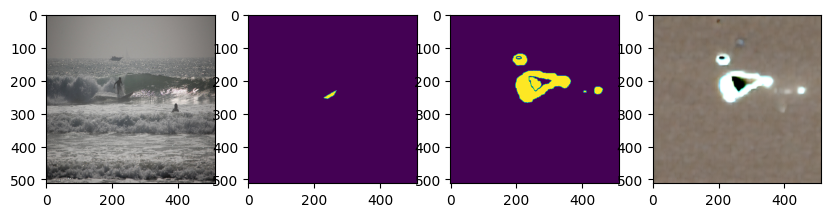

In [9]:
from training_scripts.segmentation_metrics import test_model_segmentation_on_unseen_classes

imgs_paths = './data/cocostuff/images/'
seg_paths = './data/cocostuff/annotations/'
labels_file_path = './data/cocostuff/cocostuff-labels.txt'
images_list_path = './data/cocostuff/imageLists/train.txt'
    
scores = test_model_segmentation_on_unseen_classes(imgs_paths,
                                 seg_paths,
                                 labels_file_path,
                                 images_list_path,
                                 pipe,
                                 max_examples=10,
                                 bin_segmask_threshold=200,
                                 strength=0.1,
                                 guidance_scale=12,
                                 print_every=1)

In [ ]:
for key, item in scores.items():
    print(f'{key} : {np.mean(item)}')
print(len(scores['iou']))

dice: : 0.419526259735157
iou : 0.33910701677399296
ap_mask : 0.31711064553119617
ap_detect : 0.3069306930693069
202


In [ ]:
unique, count = np.unique(img_arr.reshape(-1,3), axis=0, return_counts=True)
sorted_indices = np.argsort(count)[::-1]
unique_sorted = unique[sorted_indices]
count_sorted  = count[sorted_indices]

for i, (color, count) in enumerate(zip(unique_sorted, count_sorted)):
    print(color,':', count)
